# Compute SNR

Calculate the SNR of the recordings in the test dataset.

(Rado's implementation of SNR functions is provided at the bottom of the notebook).

**Author**: Prisca Dotti  
**Last modified**: 30/10/2023

TODO (week 44):
- ~~compute snr wrt to events only on chunk that contains them instead of all movie~~ -> does not improve results much (correlation from 0.356 to 0.392)
- ~~change range (`max_range`) in snr wrt to chunks~~ -> results can improve a bit, but I don't know what is the most legitimate choice for `max_range` (corr. went from 0.589 to 0.596 with `max_range` changed from 16 to 24
)
- ~~try different values of percentile for events in `compute_snr` to see if all events are represented in the percentile mask~~
    - for whole movies: it is basically impossible to include all events
    - for single frames: 99 is clearly too much, 70 not enough, 60 is okay in almost all frames, but then the correlation value gets event worse
    - for chunks of frames: 99 is mostly okay
    - for average of events: 99 is maybe even too small


In [1]:
# autoreload is used to reload modules automatically before entering the
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2

import sys

# To import modules from parent directory in Jupyter Notebook
sys.path.append("..")

In [2]:
import logging
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import pearsonr
import napari
from typing import List, Tuple, Optional

from utils.in_out_tools import load_movies_ids, load_annotations_ids
from data.data_processing_tools import (
    compute_snr,
    moving_average,
    keep_percentile,
    get_cell_mask,
)

plt.rcParams["figure.dpi"] = 600

logger = logging.getLogger(__name__)
sns.set_style("ticks")

### Set up notebook parameters etc.

#### Set working directories and parameters

In [3]:
# list of all movie IDs in test set
sample_ids = ["05", "10", "15", "20", "25", "32", "34", "40", "45"]
# sample_ids = ["05", "34"]

relative_path = "../data/sparks_dataset"
dataset_path = os.path.realpath(f"{relative_path}")

In [4]:
slice_to_movie_id = {
    "01": "15",
    "02": "20",
    "03": "34",
    "04": "05",
    "05": "10",
    "06": "25",
    "07": "32",
    "08": "34",
    "09": "40",
    "10": "45",
}

movie_id_to_slice = {v: k for k, v in slice_to_movie_id.items()}
slice_ids = list(slice_to_movie_id.keys())

slice_to_frame_id = {
    "01": 54,
    "02": 445,
    "03": 430,
    "04": 351,
    "05": 410,
    "06": 109,
    "07": 950,
    "08": 894,
    "09": 898,
    "10": 667,
}

##### My functions

In [36]:
def plot_snr_kappa_correlation(
    snr_list: List[float],
    fleiss_kappas_list: List[float],
    slice_ids: List[str],
    correlation: float,
    plot_title: str,
    figsize: Tuple[int, int] = (10, 10),
    palette_str: str = "colorblind",
) -> None:
    # create a figure with 3 subplots
    fig = plt.figure(figsize=figsize, dpi=600)
    gs = fig.add_gridspec(2, 2, width_ratios=[5, 4])
    palette = sns.color_palette(palette_str, n_colors=len(set(slice_ids)))

    # plot barplot of snr_experts
    ax1 = fig.add_subplot(gs[0, 0])
    sns.barplot(
        hue=slice_ids,
        x=slice_ids,
        y=snr_list,
        palette=palette,
        ax=ax1,
        legend=False,
        orient="v",
    )

    ax1.set_title("SNR ratio per sample")
    ax1.set_xlabel("Sample ID")
    ax1.set_ylabel("SNR")
    ax1.set_ylim(0, max(snr_list) + 1)
    for bars in ax1.containers:
        ax1.bar_label(bars, fmt="%.2f")
    sns.despine(ax=ax1)

    # plot barplot of binary_fleiss_kappas
    ax2 = fig.add_subplot(gs[1, 0])
    sns.barplot(
        hue=slice_ids,
        x=slice_ids,
        y=fleiss_kappas_list,
        palette=palette,
        ax=ax2,
        legend=False,
        orient="v",
    )
    ax2.set_title("'Binary' Fleiss' Kappa")
    ax2.set_xlabel("Sample ID")
    ax2.set_ylabel(r"$\kappa_{Fleiss}$")
    ax2.set_ylim(0, 1)
    for bars in ax2.containers:
        ax2.bar_label(bars, fmt="%.2f")
    sns.despine(ax=ax2)

    # plot scatter plot of snr_list vs fleiss_kappa_list
    ax3 = fig.add_subplot(gs[:, 1])

    if correlation > 0.5:
        # fit a linear regression line to the scatter plot
        sns.regplot(x=snr_list, y=fleiss_kappas_list, ax=ax3, ci=None, color="black")

    sns.scatterplot(
        x=snr_list,
        y=fleiss_kappas_list,
        hue=slice_ids,
        palette=palette,
        hue_order=slice_ids,
        ax=ax3,
        legend=False,
        s=60,
    )

    # add the correlation coefficient to the plot
    ax3.set_title("Pearsons correlation coefficient: %.3f" % correlation)
    ax3.set_xlabel("SNR")
    ax3.set_ylabel(r"$\kappa_{Fleiss}$")
    ax3.set_box_aspect(1)  # Set the aspect ratio of axes to be equal
    sns.despine(ax=ax3)

    # set the whole plot title
    fig.suptitle(plot_title)

    # remove empty space between columns
    fig.subplots_adjust(wspace=0)
    fig.tight_layout()

    # display the plot
    plt.show()


def visualize_pixel_above_percentile(
    movie_id: str,
    xs: dict,
    ys: dict,
    start_id: int = 0,
    end_id: Optional[int] = None,
    percentile: int = 50,
) -> None:
    # visualize pixels in events above percentile
    x = xs[movie_id][start_id:end_id]
    y = ys[movie_id][start_id:end_id]

    # compute percentile
    events_percentile = np.percentile(x[y != 0], percentile)
    percentile_mask = np.logical_and(x > events_percentile, y != 0)

    viewer = napari.Viewer()
    viewer.add_image(x, name=f"movie {movie_id}", colormap="gray", opacity=0.5)
    viewer.add_labels(y, name=f"events in movie {movie_id}", opacity=0.5)
    viewer.add_labels(
        percentile_mask, name="pixels in events above percentile", blending="additive"
    )

##### Rado's functions implementation

In [6]:
from skimage.morphology import binary_closing
from skimage.filters import threshold_otsu
from scipy.ndimage import binary_fill_holes


def estimate_cell_mask(cell_img: np.ndarray) -> np.ndarray:
    cell_img = np.mean(cell_img, axis=0)

    # Normalize cell image
    cell_img = cell_img / np.max(cell_img)

    # Calculate a threshold using Otsu's method
    cell_thrs = threshold_otsu(
        cell_img[
            (cell_img > np.percentile(cell_img, 1))
            & (cell_img < np.percentile(cell_img, 99))
        ]
    )

    # Create a binary thresholded cell image
    cell_img_bw_thrs = binary_fill_holes(cell_img > cell_thrs)

    # Perform edge detection and dilation to obtain cell mask
    edges_sobel = (
        cell_img > np.max(cell_img) * 0.5
    )  # You might need to fine-tune this threshold
    edges_canny = cell_img_bw_thrs

    se = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])  # Define a structuring element
    bw_dil_sobel = binary_closing(edges_sobel, se)
    bw_dil_canny = binary_closing(edges_canny, se)

    cell_mask = bw_dil_sobel | bw_dil_canny | cell_img_bw_thrs
    cell_mask = binary_fill_holes(cell_mask)

    return cell_mask


def estimate_snr(x: np.ndarray, y: np.ndarray, event_type: str) -> float:
    # Convert the image series to double
    x = x.astype(float)

    # Estimate the cell mask
    cell_mask = estimate_cell_mask(x)

    # Add the mask of events to the cell mask
    cell_mask = cell_mask | np.any(y, axis=0)
    cell_mask = np.repeat(cell_mask[np.newaxis, :, :], x.shape[0], axis=0)

    # Calculate the 99th percentile of event mask as the peak amplitude of events
    p = 99

    if event_type == "sparks":
        avg_events = np.percentile(x[cell_mask & (y == 1)], p)
    elif event_type == "puffs":
        avg_events = np.percentile(x[cell_mask & (y == 3)], p)
    elif event_type == "waves":
        avg_events = np.percentile(x[cell_mask & (y == 2)], p)
    elif event_type == "all":
        avg_events = np.percentile(x[cell_mask & np.isin(y, [1, 2, 3])], p)
    else:
        raise ValueError(
            "event_type must be one of the following: sparks, puffs, waves or all"
        )

    # Calculate the average signal from cell areas without events
    avg_baseline = np.mean(x[(y == 0) & cell_mask])

    # Estimate noise standard deviation
    sd_noise = np.std(x[(y == 0) & cell_mask])

    # Calculate SNR
    snr = (avg_events - avg_baseline) / sd_noise

    return snr

#### Load recordings

In [7]:
# load movies
xs = load_movies_ids(
    data_folder=dataset_path, ids=sample_ids, names_available=True, movie_names="video"
)

# load annotations
ys = load_annotations_ids(
    data_folder=dataset_path, ids=sample_ids, mask_names="class_label"
)

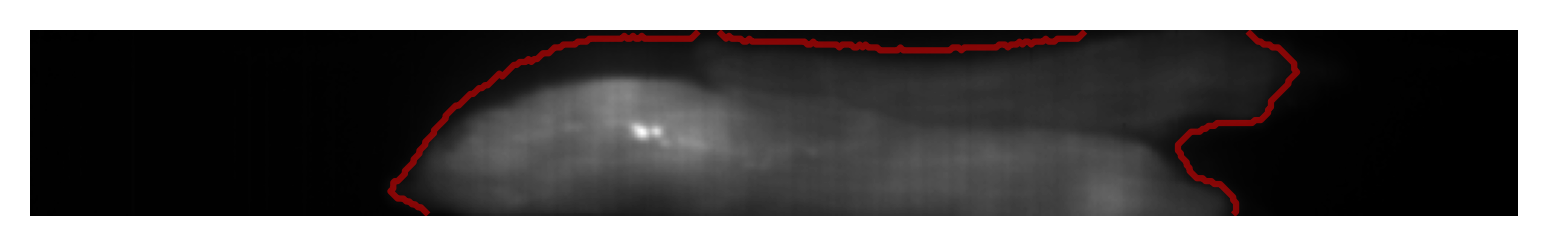

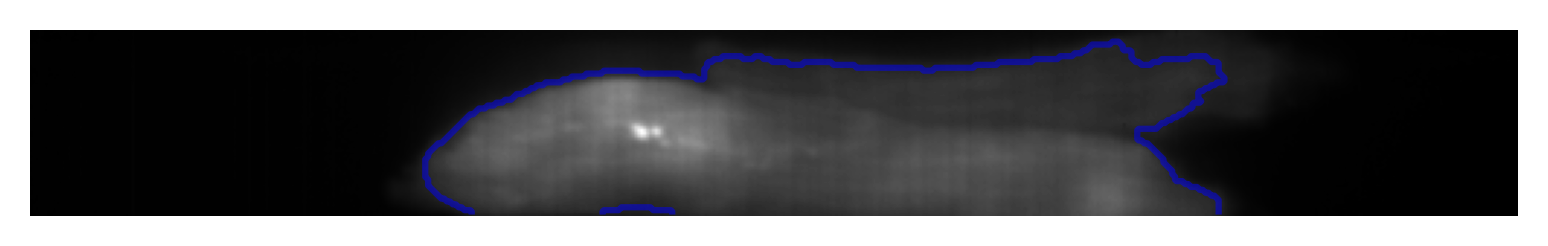

In [8]:
sample_id = "34"
x = xs[sample_id]
y = ys[sample_id]
cell_mask = get_cell_mask(x)

# plot image and contours
fig, ax = plt.subplots()
ax.imshow(np.mean(x, axis=0), cmap="gray")
ax.contour(cell_mask, colors="red", alpha=0.5)
ax.axis("off")
plt.show()

rado_cell_mask = estimate_cell_mask(x)

# plot image and contours
fig, ax = plt.subplots()
ax.imshow(np.mean(x, axis=0), cmap="gray")
ax.contour(rado_cell_mask, colors="blue", alpha=0.5)
ax.axis("off")
plt.show()

## Get Fleiss' Kappa values

In [9]:
# Fleiss' Kappa for inter-rater agreement
fleiss_kappas = {
    "01": 0.4,
    "02": 0.263,
    "03": 0.393,
    "04": 0.499,
    "05": 0.411,
    "06": 0.210,
    "07": 0.140,
    "08": 0.635,
    "09": 0.817,
    "10": 0.776,
}

binary_fleiss_kappas = {
    "01": 0.423724,
    "02": 0.379940,
    "03": 0.535884,
    "04": 0.626976,
    "05": 0.587802,
    "06": 0.275065,
    "07": 0.140142,
    "08": 0.764101,
    "09": 0.820575,
    "10": 0.775755,
}

fleiss_kappas_list = [
    kappa
    for slice_id, kappa in fleiss_kappas.items()
    if slice_to_movie_id[slice_id] in sample_ids
]

binary_fleiss_kappas_list = [
    kappa
    for slice_id, kappa in binary_fleiss_kappas.items()
    if slice_to_movie_id[slice_id] in sample_ids
]

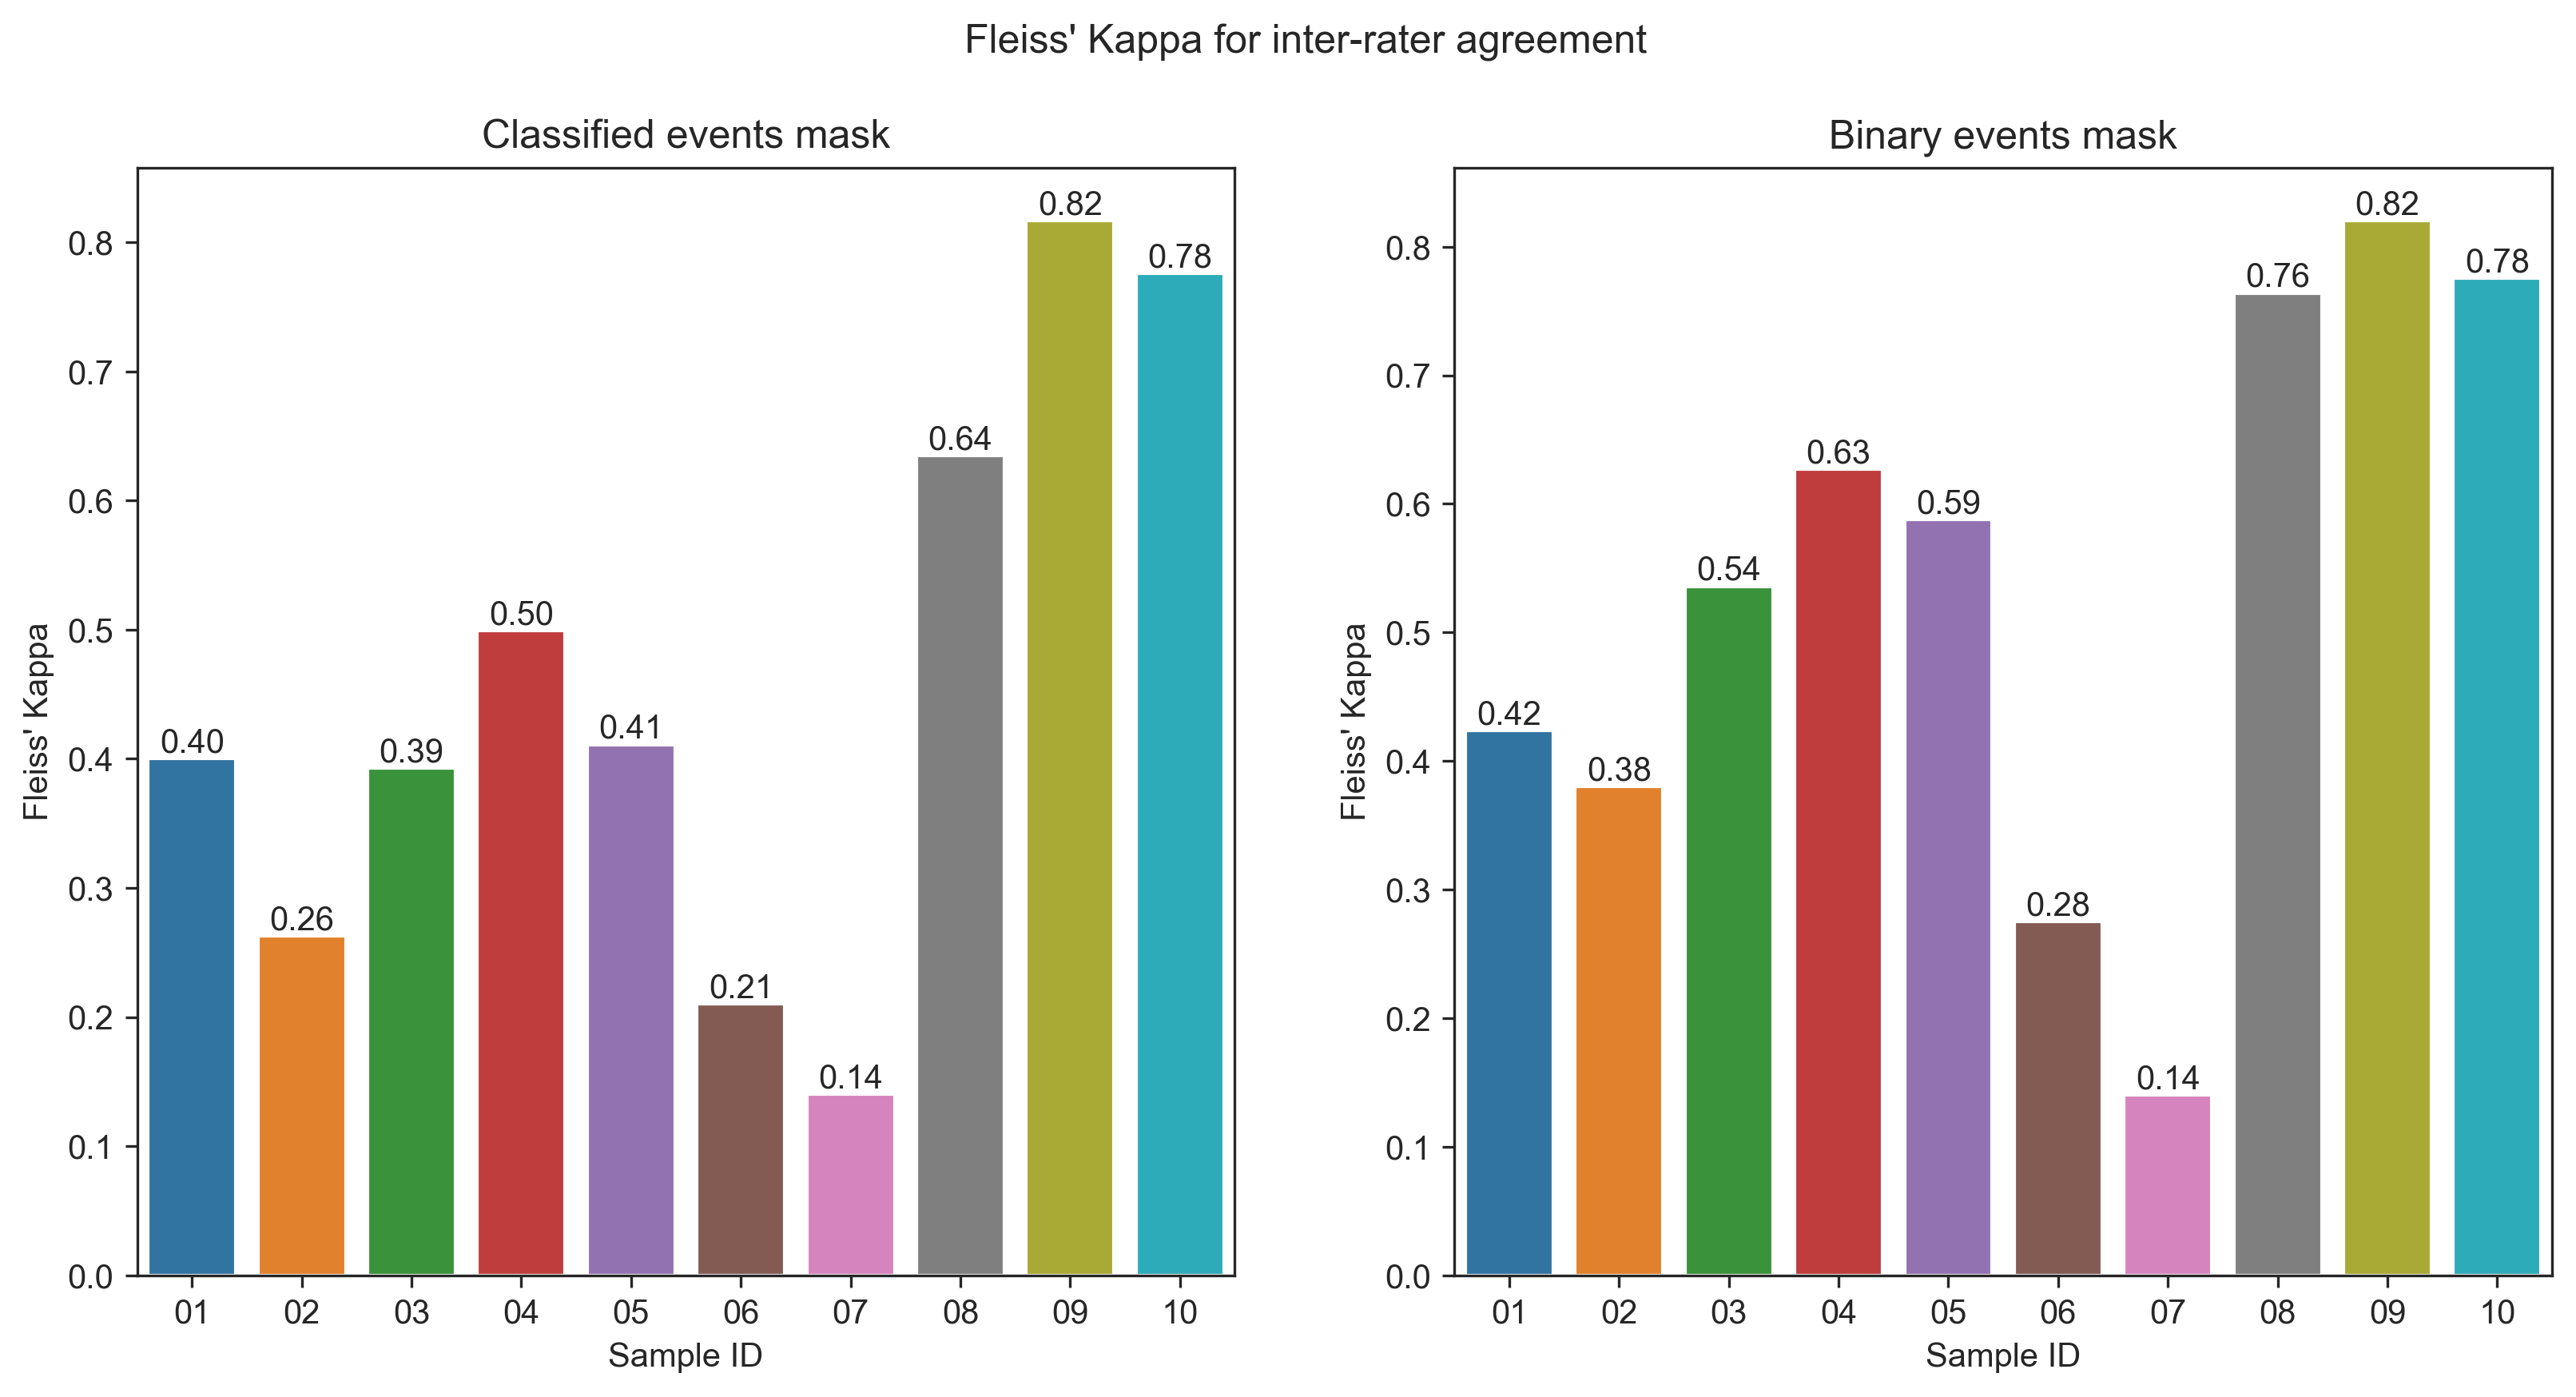

In [10]:
# create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13, 6))

# visualize snr and fleiss kappas as scatterplot
sns.barplot(
    x=slice_ids,
    hue=slice_ids,
    y=fleiss_kappas_list,
    ax=ax1,
    legend=False,
)
ax1.set_title("Classified events mask")
ax1.set_xlabel("Sample ID")
ax1.set_ylabel("Fleiss' Kappa")
for bars in ax1.containers:
    ax1.bar_label(bars, fmt="%.2f")

# visualize snr and binary fleiss kappas as scatterplot
sns.barplot(
    x=slice_ids,
    hue=slice_ids,
    y=binary_fleiss_kappas_list,
    ax=ax2,
    legend=False,
)
ax2.set_title("Binary events mask")
ax2.set_xlabel("Sample ID")
ax2.set_ylabel("Fleiss' Kappa")
for bars in ax2.containers:
    ax2.bar_label(bars, fmt="%.2f")

# set figure title
fig.suptitle("Fleiss' Kappa for inter-rater agreement")

# display the plot
plt.show()

## Compute SNR using various approaches

### For whole movies

In [11]:
snr_whole_movies = {}
percentile = 90

for sample_id in sample_ids:
    # get sample
    x = xs[sample_id]
    # get annotations
    y = ys[sample_id]

    # compute signal-to-noise ratio
    snr_whole_movies[sample_id] = compute_snr(x, y, percentile=percentile)

# get snr with respect to samples given to experts for inter-rater agreement
snr_whole_movies_experts = {
    slice_id: snr_whole_movies[slice_to_movie_id[slice_id]]
    for slice_id in slice_ids
    if slice_to_movie_id[slice_id] in sample_ids
}

#### Compute correlation with Fleiss' kappa for whole movies

In [12]:
# check if there is a correlation between snr and fleiss kappas
snr_whole_movies_list = list(snr_whole_movies_experts.values())
whole_movie_corr, _ = pearsonr(snr_whole_movies_list, fleiss_kappas_list)
print("Pearsons correlation for classified segmentation: %.3f" % whole_movie_corr)

# check if there is a correlation between snr and binary fleiss kappas
binary_whole_movie_corr, _ = pearsonr(snr_whole_movies_list, binary_fleiss_kappas_list)
print("Pearsons correlation for binary segmentation: %.3f" % binary_whole_movie_corr)

Pearsons correlation for classified segmentation: 0.306
Pearsons correlation for binary segmentation: 0.489


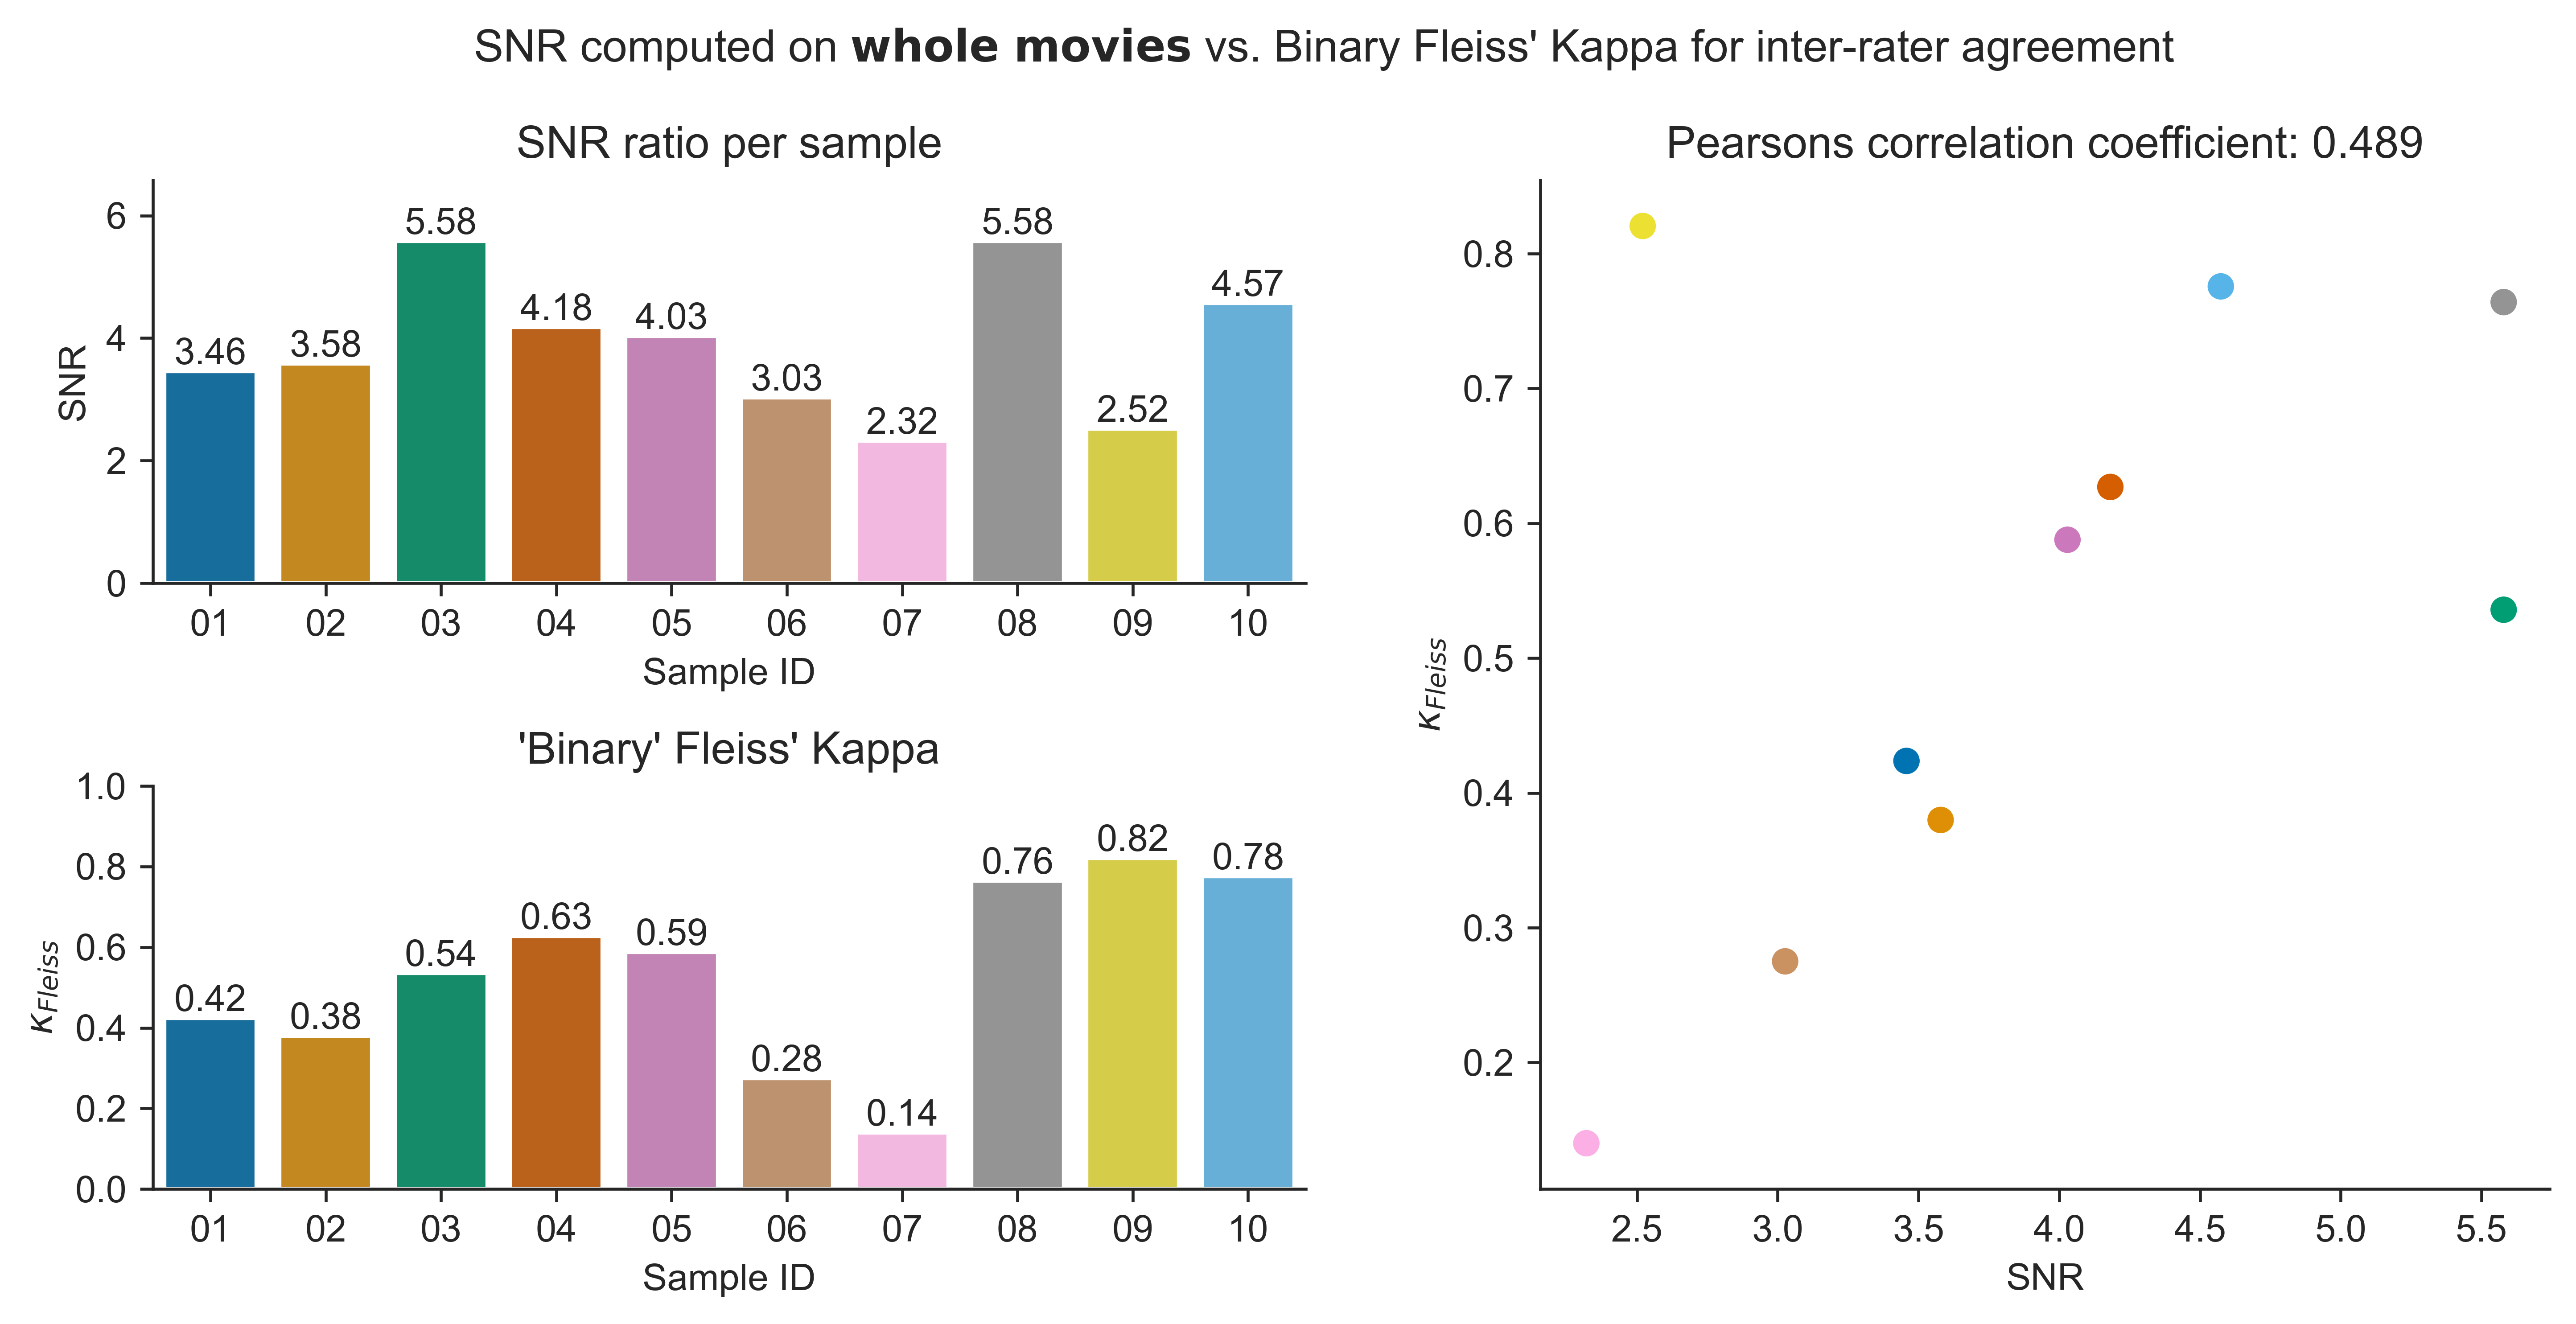

In [33]:
plot_snr_kappa_correlation(
    snr_list=snr_whole_movies_list,
    fleiss_kappas_list=binary_fleiss_kappas_list,
    slice_ids=slice_ids,
    correlation=binary_whole_movie_corr,
    plot_title=r"SNR computed on $\bf{whole\ movies}$ vs. Binary Fleiss' Kappa for inter-rater agreement",
    figsize=(10, 5),
)

In [14]:
# for slice_id in ["01"]:  # slice_ids:
#     movie_id = slice_to_movie_id[slice_id]
#     visualize_pixel_above_percentile(
#         movie_id=movie_id,
#         xs=xs,
#         ys=ys,
#         percentile=percentile,
#     )

### Compute SNR for single frames

In [15]:
snr_frames = {}
percentile = 90

for slice_id in slice_ids:
    movie_id = slice_to_movie_id[slice_id]
    frame_id = slice_to_frame_id[slice_id]
    if movie_id not in sample_ids:
        continue

    # get sample frame
    x = xs[movie_id][frame_id]
    # get annotations frame
    y = ys[movie_id][frame_id]

    # compute signal-to-noise ratio
    snr_frames[slice_id] = compute_snr(x, y, percentile=percentile)

#### Compute correlation for single frames

In [16]:
# check if there is a correlation between snr and fleiss kappas
snr_frames_list = list(snr_frames.values())
single_frame_corr, _ = pearsonr(snr_frames_list, fleiss_kappas_list)
print("Pearsons correlation for classified segmentation: %.3f" % single_frame_corr)

# check if there is a correlation between snr and binary fleiss kappas
binary_single_frame_corr, _ = pearsonr(snr_frames_list, binary_fleiss_kappas_list)
print("Pearsons correlation for binary segmentation: %.3f" % binary_single_frame_corr)

Pearsons correlation for classified segmentation: 0.072
Pearsons correlation for binary segmentation: 0.291


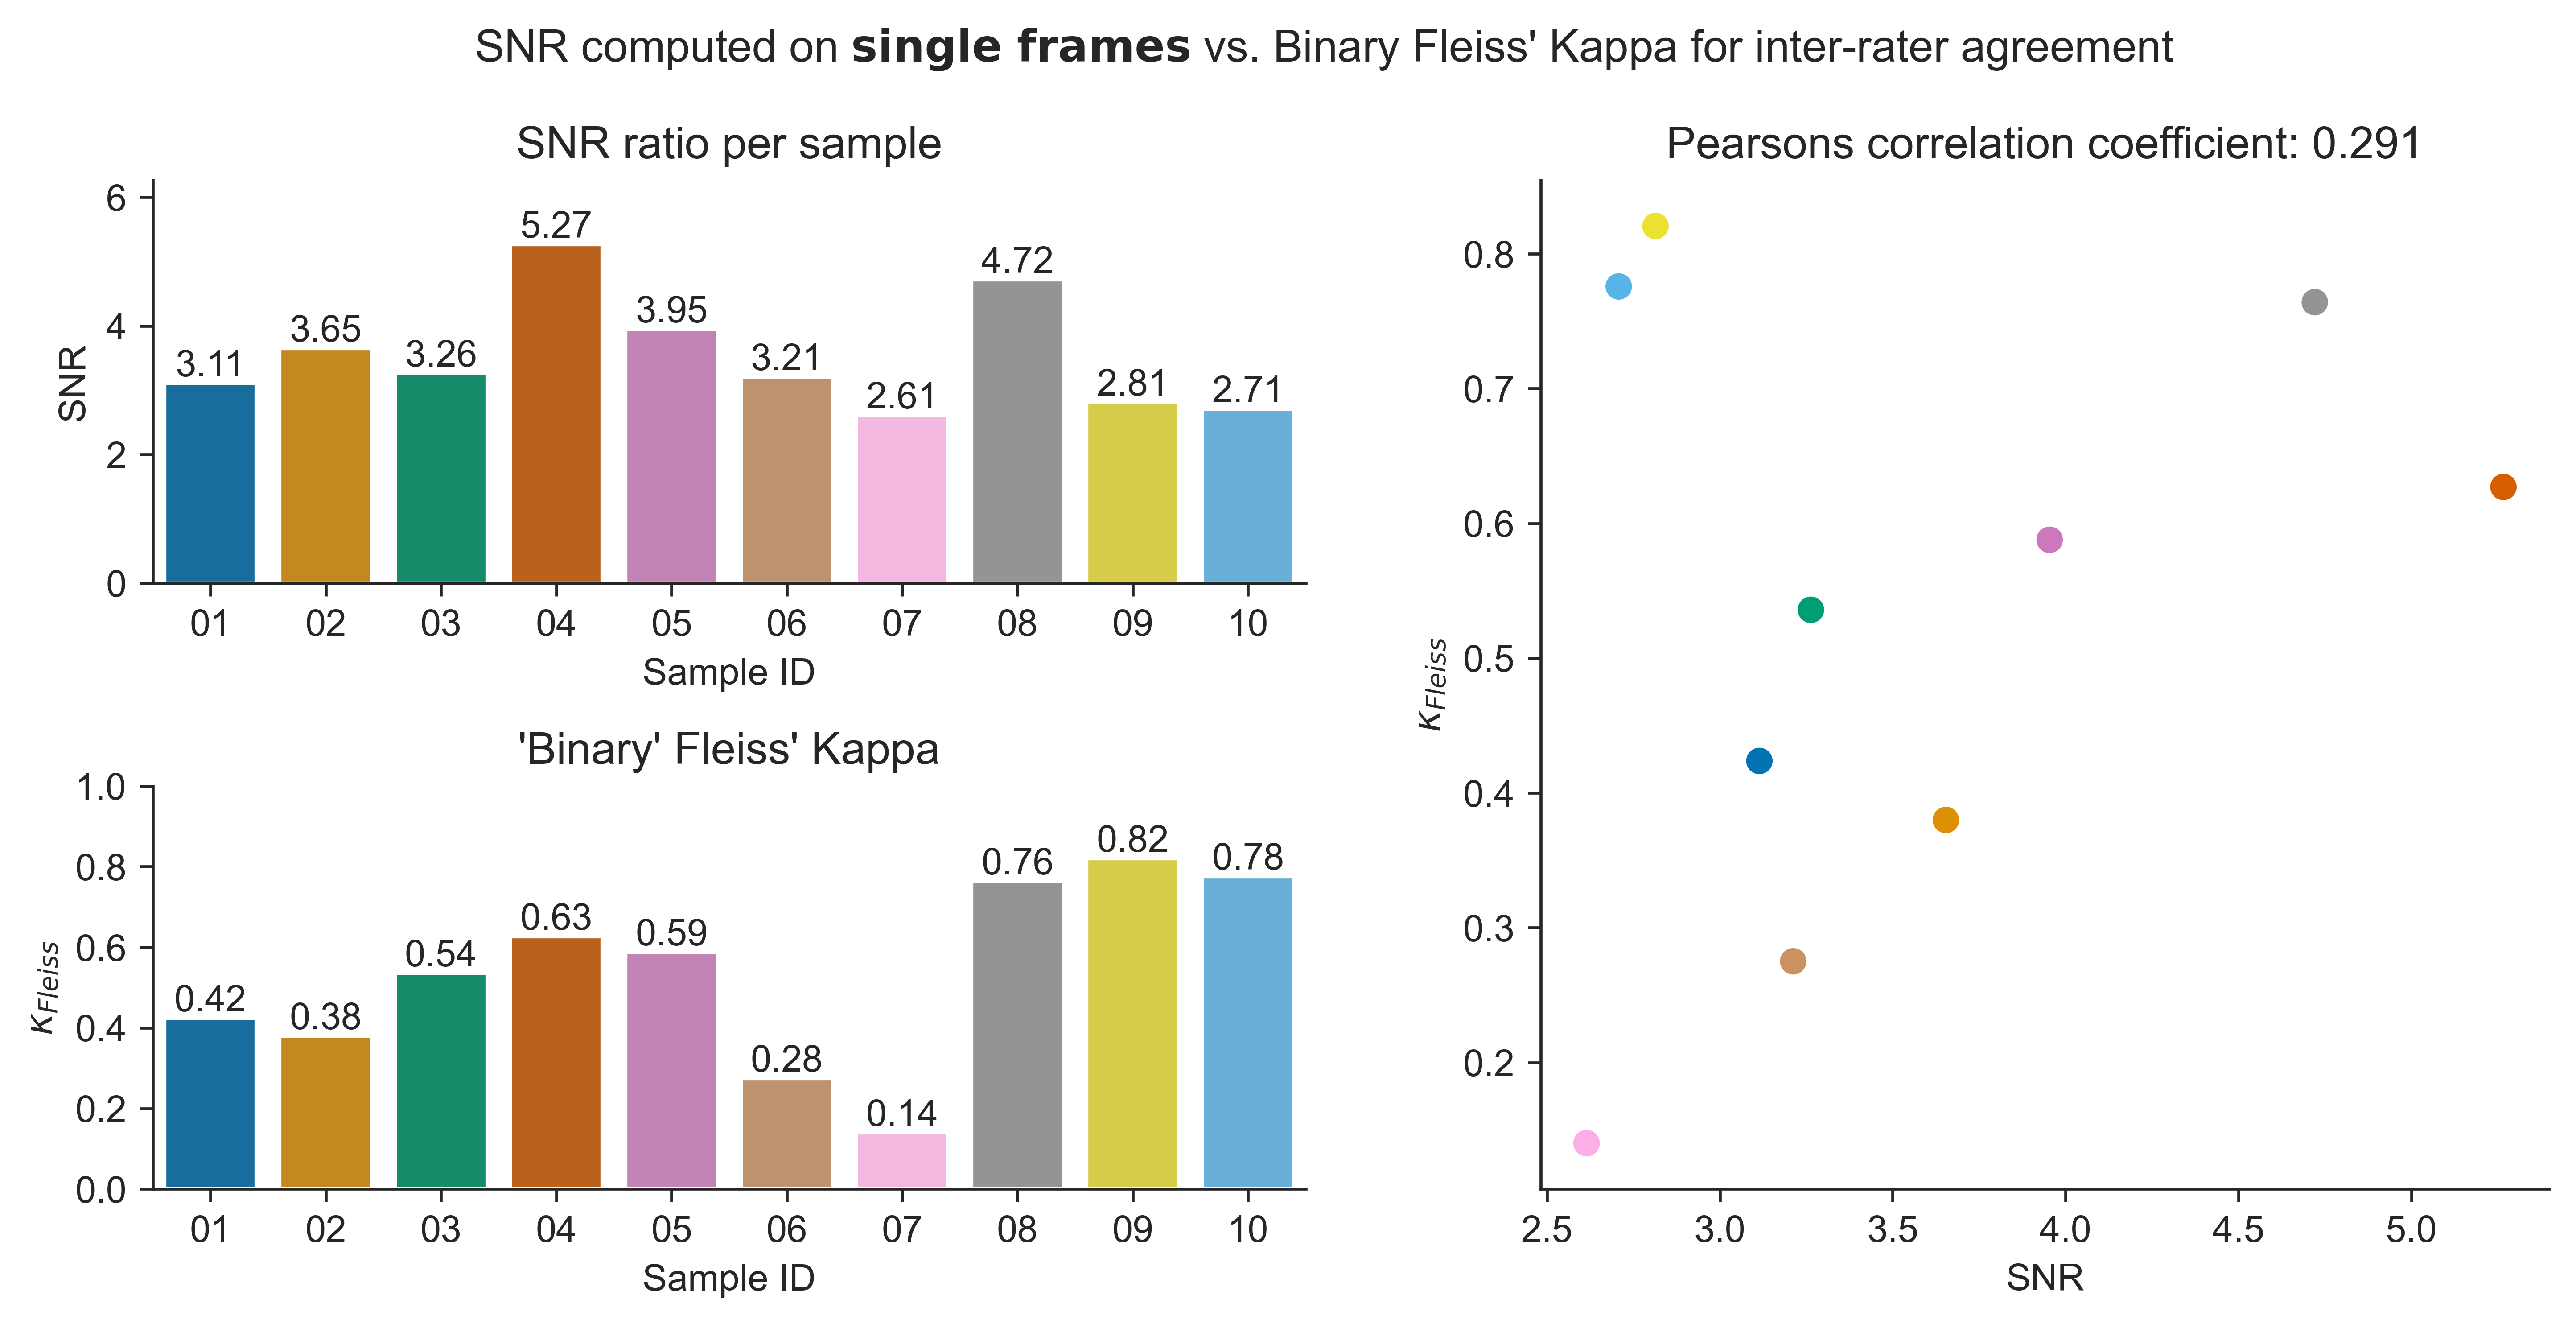

In [17]:
plot_snr_kappa_correlation(
    snr_list=snr_frames_list,
    fleiss_kappas_list=binary_fleiss_kappas_list,
    slice_ids=slice_ids,
    correlation=binary_single_frame_corr,
    plot_title=r"SNR computed on $\bf{single\ frames}$ vs. Binary Fleiss' Kappa for inter-rater agreement",
    figsize=(10, 5),
)

In [18]:
# for slice_id in ["01"]:  # slice_ids:
#     movie_id = slice_to_movie_id[slice_id]
#     frame_id = slice_to_frame_id[slice_id]
#     visualize_pixel_above_percentile(
#         movie_id=movie_id,
#         xs=xs,
#         ys=ys,
#         start_id=frame_id,
#         end_id=frame_id + 1,
#         percentile=percentile,
#     )

### Compute SNR for chunks containing whole events present in slices

In [19]:
# load instance masks for all samples
ys_instances = load_annotations_ids(
    data_folder=dataset_path, ids=sample_ids, mask_names="event_label"
)

# Get start and end frames of considered chunk for each sample
start_ids = {}
end_ids = {}

chunk_duration = 24  # maximum range of frames to consider

tot_events = 0
shortened_chunks = 0

for slice_id in slice_ids:
    # print("Slice ID: ", slice_id)
    movie_id = slice_to_movie_id[slice_id]
    frame_id = slice_to_frame_id[slice_id]

    if movie_id not in sample_ids:
        continue
    # get all unique event labels in the frame
    event_labels = np.unique(ys_instances[movie_id][frame_id])
    # remove 0 from event_labels
    event_labels = event_labels[event_labels != 0]

    # create variables to store the start and end frames
    start_id = frame_id
    end_id = frame_id

    # loop through each event label
    for event_label in event_labels:
        # print("Event label: ", event_label)
        # get the indices where the event label is present in the frame
        event_indices_list = np.where(ys_instances[movie_id] == event_label)[0]

        # update start_id and end_id
        start_id = min(start_id, event_indices_list[0])
        # print("\tFirst frame containing event: ", start_id)
        end_id = max(end_id, event_indices_list[-1])
        # print("\tLast frame containing event: ", end_id)

        if start_id < frame_id - chunk_duration or end_id > frame_id + chunk_duration:
            shortened_chunks += 1

        start_id = max(start_id, frame_id - chunk_duration)
        # print("\tSelected start frame: ", start_id)
        end_id = min(end_id, frame_id + chunk_duration)
        # print("\tSelected end frame: ", end_id)

    tot_events += len(event_labels)

    start_ids[slice_id] = start_id
    end_ids[slice_id] = end_id


print("Total number of events: ", tot_events)
print("Number of shortened chunks: ", shortened_chunks)
print("Percentage of shortened chunks: ", (shortened_chunks / tot_events) * 100, "%")

percentile = 99

snr_whole_events = {}
for slice_id in slice_ids:
    movie_id = slice_to_movie_id[slice_id]
    if movie_id not in sample_ids:
        continue

    # get chunk of frames
    start_id = start_ids[slice_id]
    end_id = end_ids[slice_id]
    x_chunk = xs[movie_id][start_id : end_id + 1]
    y_chunk = ys[movie_id][start_id : end_id + 1]

    # compute signal-to-noise ratio
    snr_whole_events[slice_id] = compute_snr(x_chunk, y_chunk, percentile=percentile)

Total number of events:  42
Number of shortened chunks:  22
Percentage of shortened chunks:  52.38095238095239 %


#### Compute correlation for chunks containing whole events present in slices

In [20]:
# check if there is a correlation between snr and fleiss kappas
snr_whole_events_list = list(snr_whole_events.values())
whole_events_corr, _ = pearsonr(snr_whole_events_list, fleiss_kappas_list)
print("Pearsons correlation for classified segmentation: %.3f" % whole_events_corr)

# check if there is a correlation between snr and binary fleiss kappas
binary_whole_events_corr, _ = pearsonr(snr_whole_events_list, binary_fleiss_kappas_list)
print("Pearsons correlation for binary segmentation: %.3f" % binary_whole_events_corr)

Pearsons correlation for classified segmentation: 0.215
Pearsons correlation for binary segmentation: 0.449


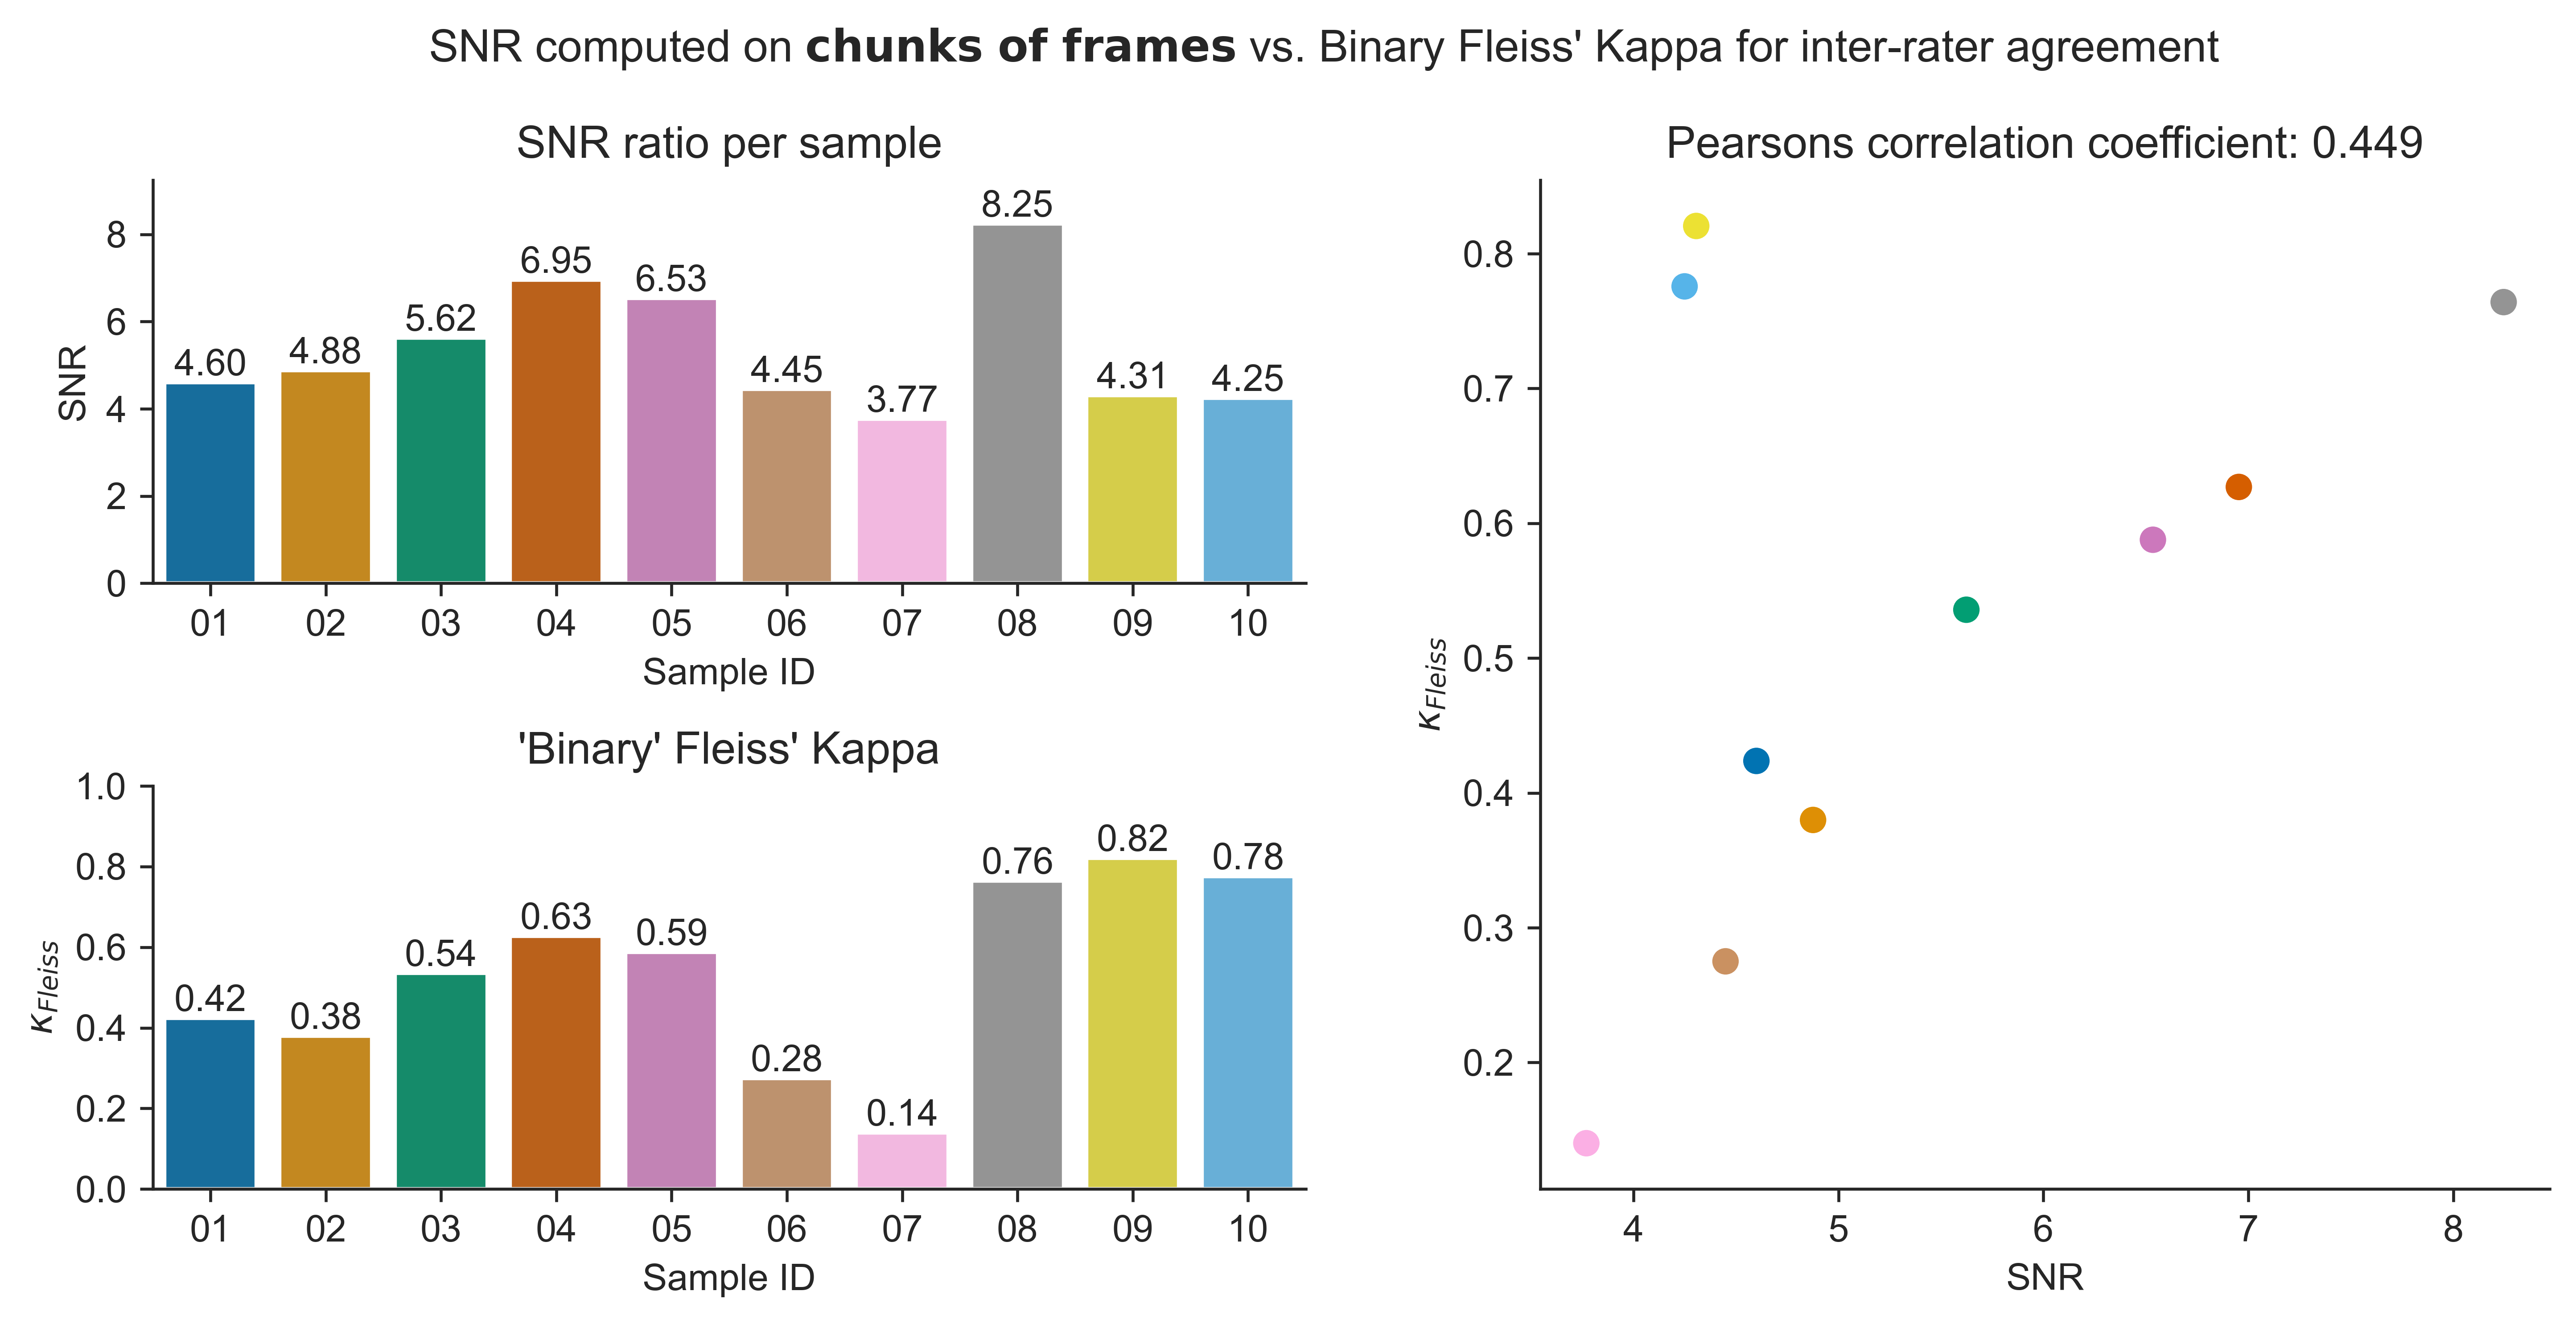

In [21]:
plot_snr_kappa_correlation(
    snr_list=snr_whole_events_list,
    fleiss_kappas_list=binary_fleiss_kappas_list,
    slice_ids=slice_ids,
    correlation=binary_whole_events_corr,
    plot_title=r"SNR computed on $\bf{chunks\ of\ frames}$ vs. Binary Fleiss' Kappa for inter-rater agreement",
    figsize=(10, 5),
)

In [22]:
# for slice_id in ["01"]:  # slice_ids:
#     movie_id = slice_to_movie_id[slice_id]
#     visualize_pixel_above_percentile(
#         movie_id=movie_id,
#         xs=xs,
#         ys=ys,
#         start_id=start_ids[slice_id],
#         end_id=end_ids[slice_id] + 1,
#         percentile=60,
#     )

### Compute average SNR of events present in each slice

In [23]:
# load instance masks for all samples
percentile = 99.9
ys_instances = load_annotations_ids(
    data_folder=dataset_path, ids=sample_ids, mask_names="event_label"
)

# initialize dictionary to store average SNR for each slice_id
avg_snr_events = {}

for slice_id in slice_ids:
    movie_id = slice_to_movie_id[slice_id]
    frame_id = slice_to_frame_id[slice_id]

    if movie_id not in sample_ids:
        continue

    x = xs[movie_id]
    y = ys[movie_id]
    y = ys_instances[movie_id]

    # get all unique event labels in the frame
    event_labels = np.unique(y[frame_id])
    # remove 0 from event_labels
    event_labels = event_labels[event_labels != 0]

    # initialize list to store SNR for each event instance
    snr_list = []

    # loop through each event label
    for event_label in event_labels:
        event_roi = y == event_label

        # get first and last frames of event_roi
        event_indices_list = np.where(event_roi == 1)[0]
        start_id = event_indices_list[0]
        end_id = event_indices_list[-1]

        # compute signal-to-noise ratio
        snr_event = compute_snr(
            x=x[start_id:end_id],
            y=y[start_id:end_id],
            event_roi=event_roi[start_id:end_id],
            percentile=percentile,
        )
        snr_list.append(snr_event)

    # compute the average SNR for all event instances in the slice_id
    avg_snr_events[slice_id] = np.mean(snr_list)

#### Compute correlation of average of events present in each slice

In [24]:
# check if there is a correlation between snr and fleiss kappas
avg_snr_events_list = list(avg_snr_events.values())
events_avg_corr, _ = pearsonr(avg_snr_events_list, fleiss_kappas_list)
print("Pearsons correlation for classified segmentation: %.3f" % events_avg_corr)

# check if there is a correlation between snr and binary fleiss kappas
binary_events_avg_corr, _ = pearsonr(avg_snr_events_list, binary_fleiss_kappas_list)
print("Pearsons correlation for binary segmentation: %.3f" % binary_events_avg_corr)

Pearsons correlation for classified segmentation: 0.180
Pearsons correlation for binary segmentation: 0.298


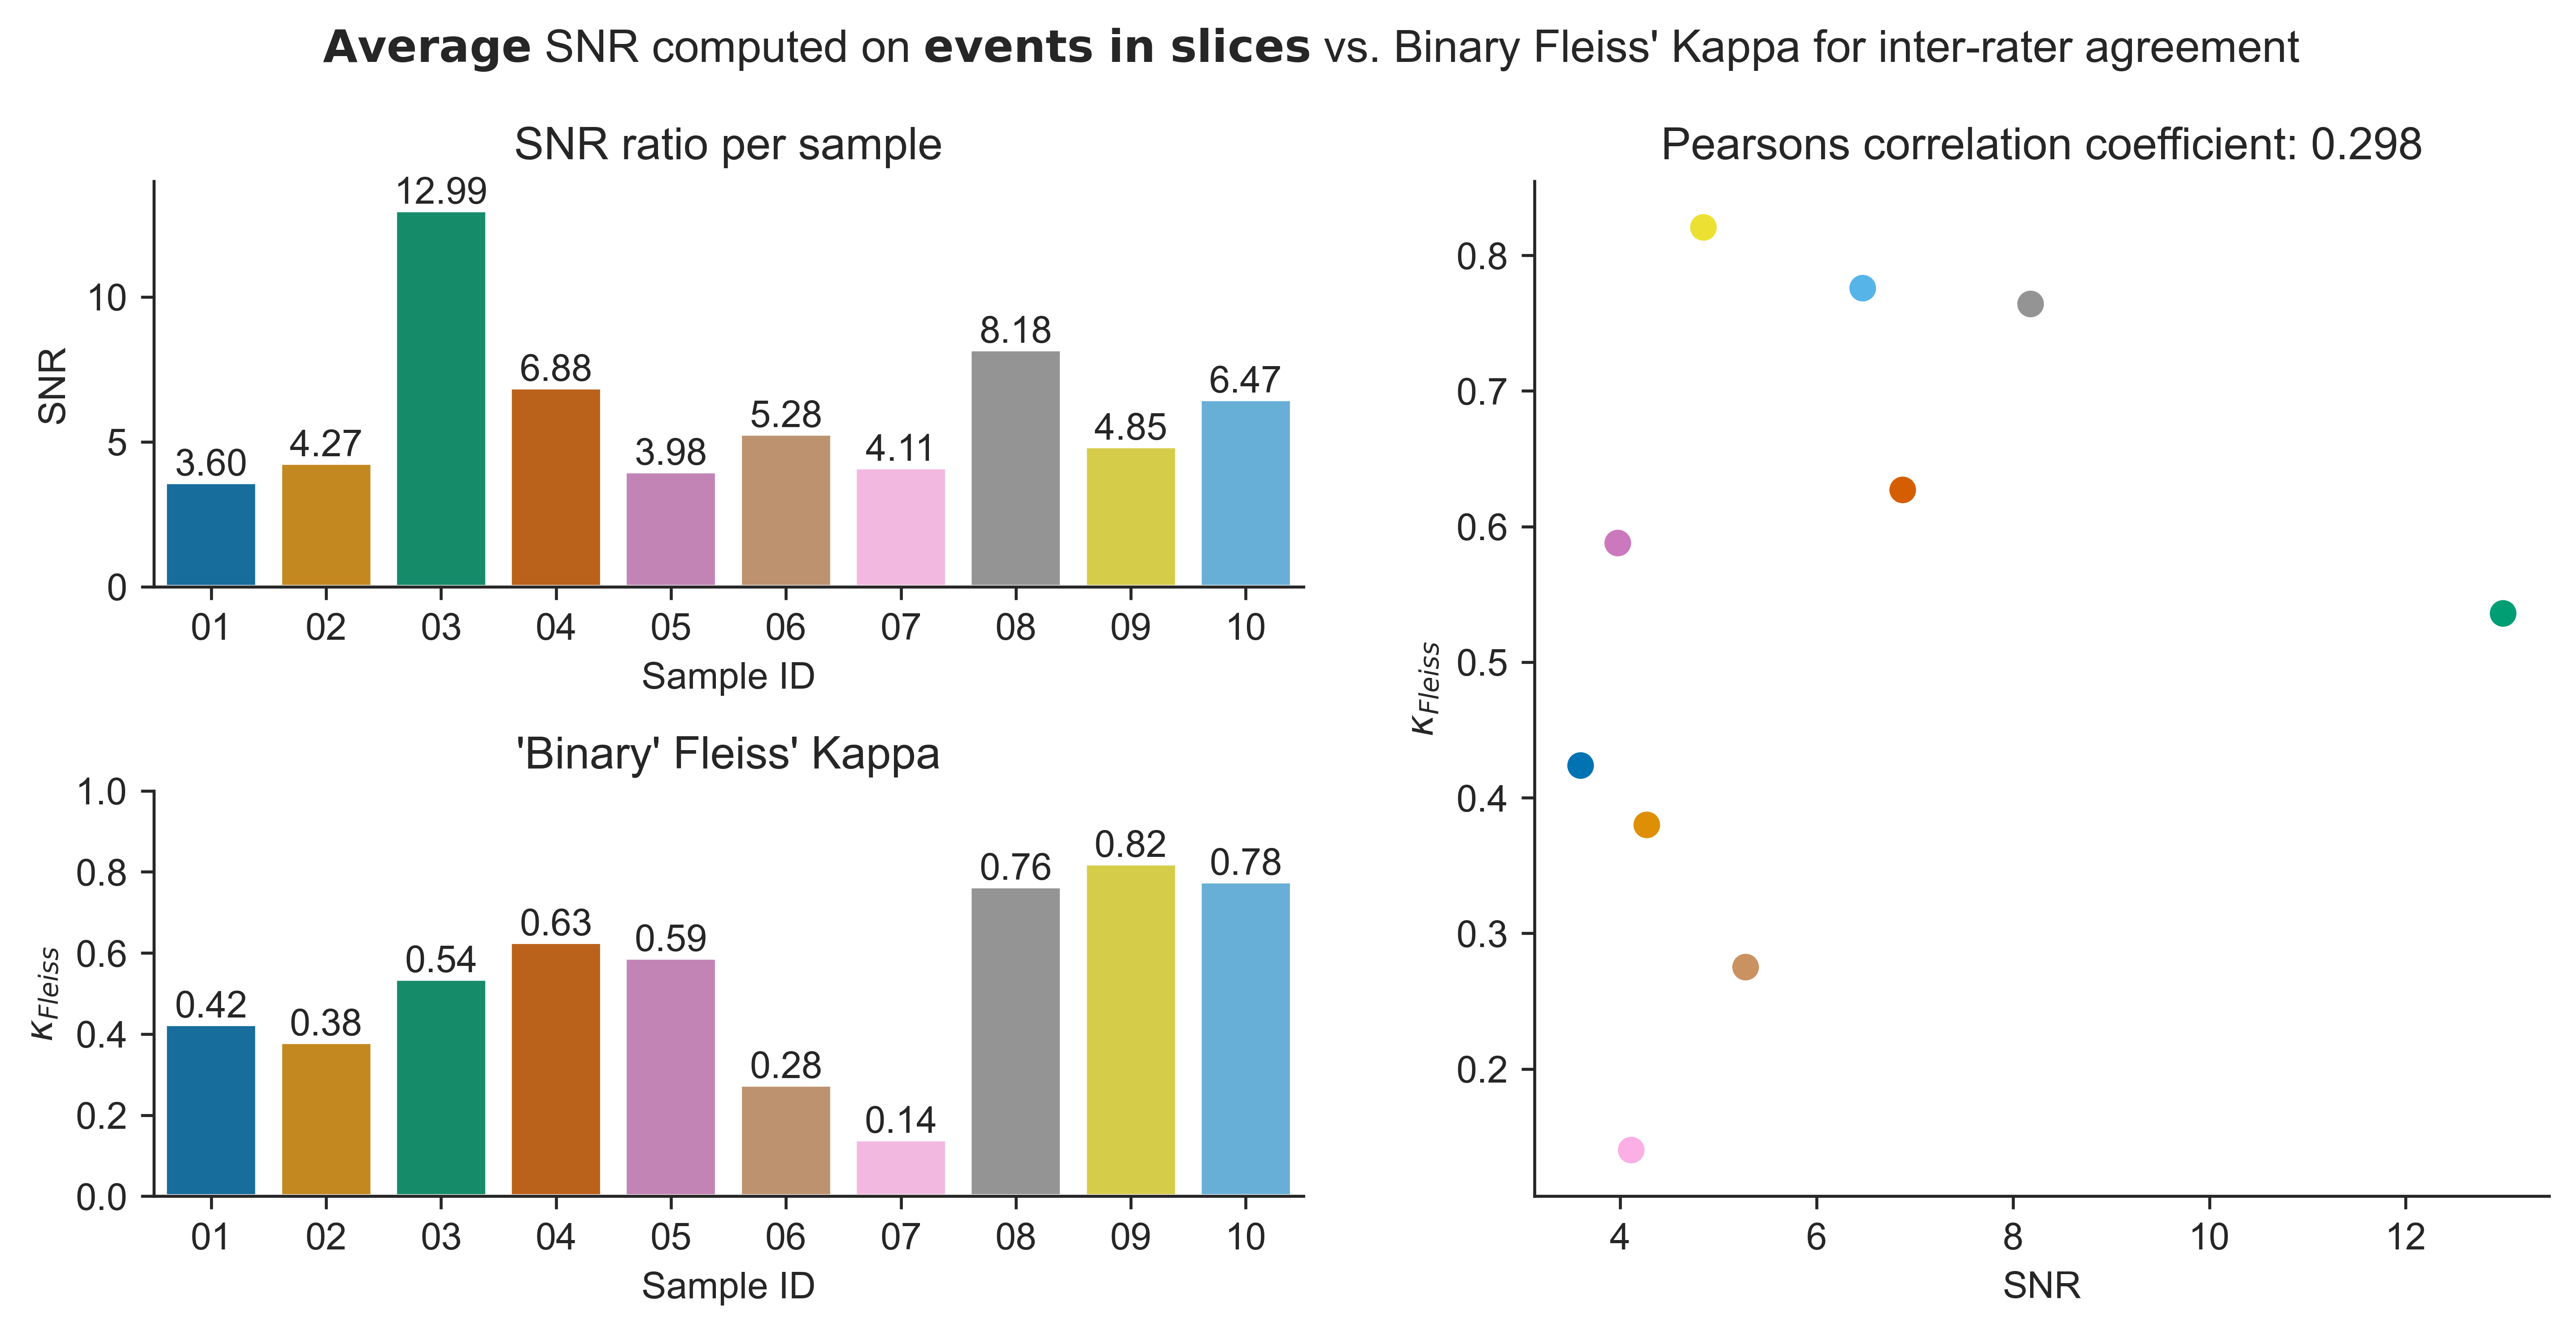

In [25]:
plot_snr_kappa_correlation(
    snr_list=avg_snr_events_list,
    fleiss_kappas_list=binary_fleiss_kappas_list,
    slice_ids=slice_ids,
    correlation=binary_events_avg_corr,
    plot_title=r"$\bf{Average}$ SNR computed on $\bf{events\ in\ slices}$ vs. Binary Fleiss' Kappa for inter-rater agreement",
    figsize=(10, 5),
)

In [26]:
# # visualize pixels in events above percentile
# for slice_id in slice_ids:
#     movie_id = slice_to_movie_id[slice_id]
#     frame_id = slice_to_frame_id[slice_id]

#     if movie_id not in sample_ids:
#         continue

#     x = xs[movie_id]
#     y = ys[movie_id]
#     y = ys_instances[movie_id]

#     # get all unique event labels in the frame
#     event_labels = np.unique(y[frame_id])
#     # remove 0 from event_labels
#     event_labels = event_labels[event_labels != 0]

#     viewer = napari.Viewer()
#     viewer.add_image(
#         x,
#         name=f"movie {slice_to_movie_id[slice_id]}, for frame {frame_id}",
#         colormap="gray",
#         opacity=0.5,
#     )
#     viewer.add_labels(
#         y, name=f"events in movie {slice_to_movie_id[slice_id]}", opacity=0.5
#     )

#     # compute percentile
#     percentile = 60
#     # loop through each event label
#     for event_label in event_labels:
#         event_roi = y == event_label

#         # get first and last frames of event_roi
#         event_indices_list = np.where(event_roi == 1)[0]
#         start_id = event_indices_list[0]
#         end_id = event_indices_list[-1]

#         x_chunk = x[start_id:end_id]
#         y_chunk = y[start_id:end_id]

#         events_percentile = np.percentile(x_chunk[y_chunk != 0], percentile)
#         percentile_mask = np.logical_and(x > events_percentile, event_roi)

#         viewer.add_labels(
#             percentile_mask, name=f"pixels in event {event_label} above percentile", blending="additive"
#         )

### Compute SNR for chunks of fixed length

In [27]:
chunk_duration = 32
half_chunk_duration = chunk_duration // 2

# Get start and end frames of considered chunk for each sample
start_ids = {}
end_ids = {}
snr_chunks = {}
percentile = 99

for slice_id in slice_ids:
    movie_id = slice_to_movie_id[slice_id]
    if movie_id not in sample_ids:
        continue

    frame_id = slice_to_frame_id[slice_id]
    movie_duration = xs[movie_id].shape[0]

    # get indices of 'chunk_duration' frames centered around 'frame_id' if possible
    start_id = max(frame_id - half_chunk_duration, 0)
    end_id = start_id + chunk_duration

    # if end_id is out of bounds, shift the chunk to the left
    if end_id > movie_duration:
        end_id = movie_duration
        start_id = end_id - chunk_duration

    start_ids[slice_id] = start_id
    end_ids[slice_id] = end_id

    # get chunk of frames
    x_chunk = xs[movie_id][start_id : end_id + 1]
    y_chunk = ys[movie_id][start_id : end_id + 1]

    # compute signal-to-noise ratio
    snr_chunks[slice_id] = compute_snr(x_chunk, y_chunk, percentile=percentile)

#### Compute correlation for chunks containing whole events present in slices

In [28]:
# check if there is a correlation between snr and fleiss kappas
snr_chunks_list = list(snr_chunks.values())
chunks_corr, _ = pearsonr(snr_chunks_list, fleiss_kappas_list)
print("Pearsons correlation for classified segmentation: %.3f" % chunks_corr)

# check if there is a correlation between snr and binary fleiss kappas
binary_chunks_corr, _ = pearsonr(snr_chunks_list, binary_fleiss_kappas_list)
print("Pearsons correlation for binary segmentation: %.3f" % binary_chunks_corr)

Pearsons correlation for classified segmentation: 0.234
Pearsons correlation for binary segmentation: 0.461


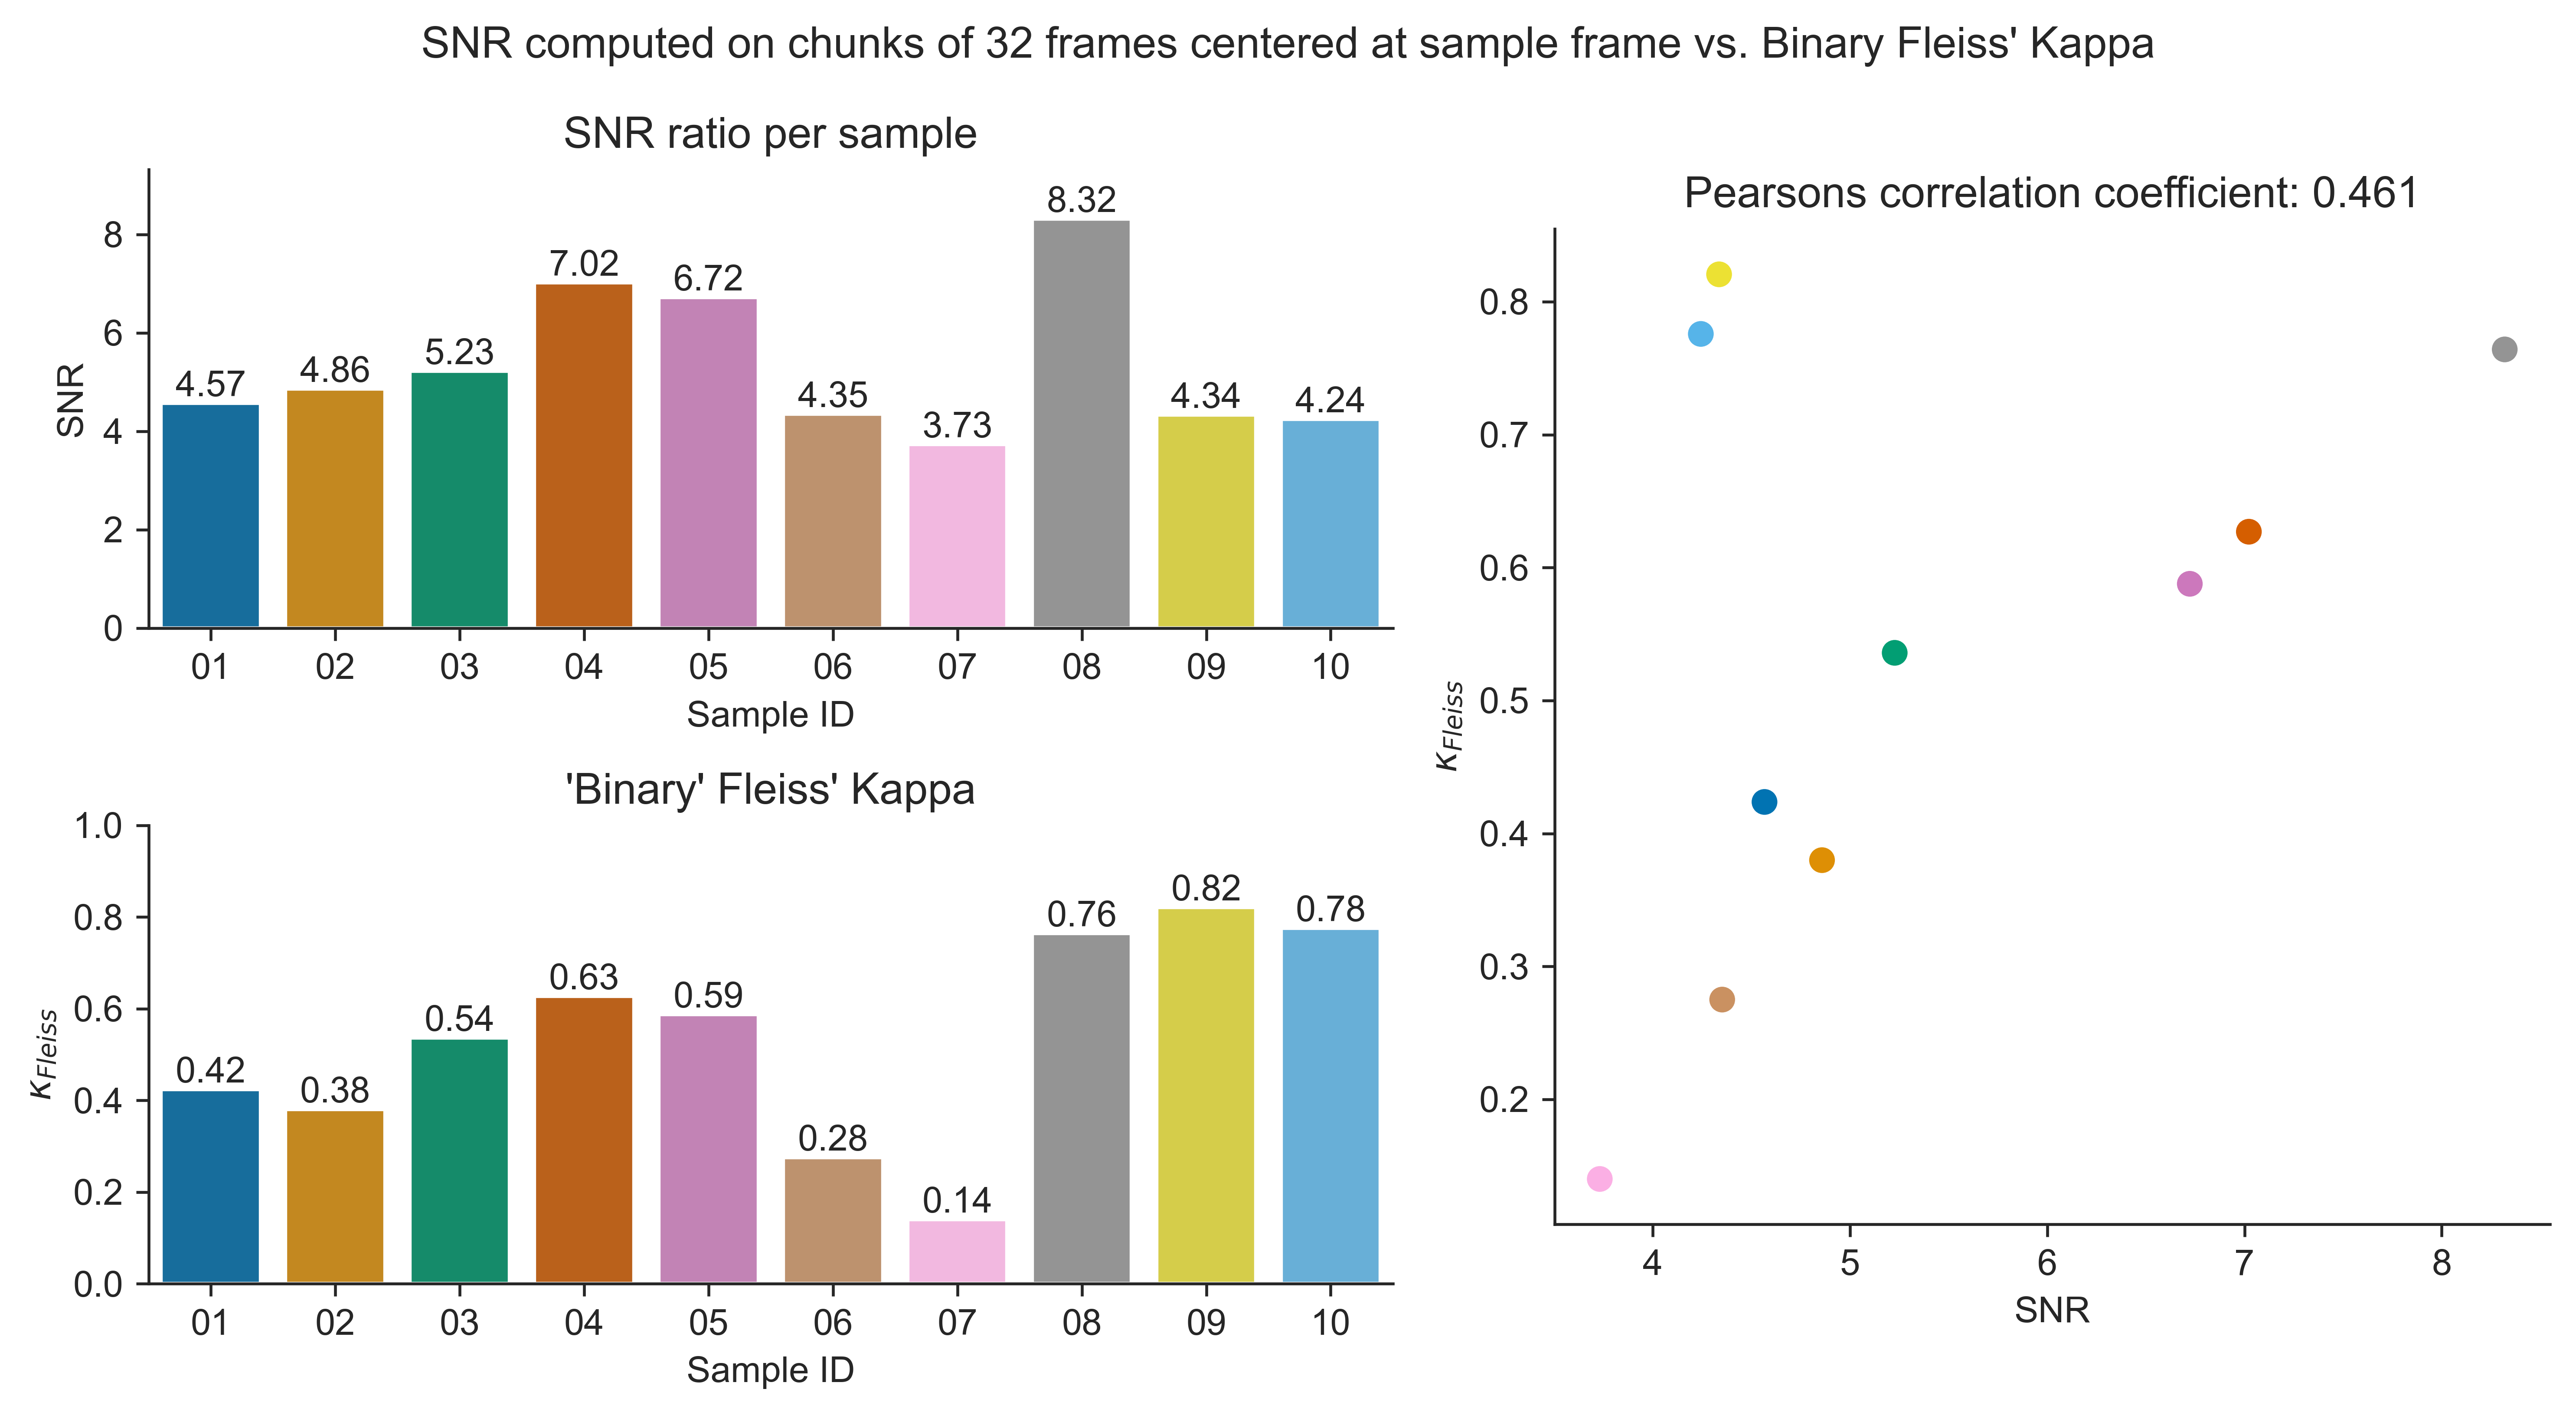

In [38]:
plot_snr_kappa_correlation(
    snr_list=snr_chunks_list,
    fleiss_kappas_list=binary_fleiss_kappas_list,
    slice_ids=slice_ids,
    correlation=binary_chunks_corr,
    plot_title=f"SNR computed on chunks of {chunk_duration} frames centered at sample frame vs. Binary Fleiss' Kappa",
    figsize=(10, 5.5),
    palette_str="colorblind",
)

In [30]:
# compute correlation excluding slice 09 and 10
filtered_slices = ["01", "02", "03", "04", "05", "06", "07", "08"]
filtered_fleiss_kappas_list = [
    kappa for slice_id, kappa in fleiss_kappas.items() if slice_id in filtered_slices
]
filtered_binary_fleiss_kappas_list = [
    kappa
    for slice_id, kappa in binary_fleiss_kappas.items()
    if slice_id in filtered_slices
]
filtered_snr_chunks_list = [snr_chunks[slice_id] for slice_id in filtered_slices]

filtered_chunks_corr, _ = pearsonr(
    filtered_snr_chunks_list, filtered_fleiss_kappas_list
)
print(
    "Pearsons correlation for classified segmentation excluding slices 09 and 10: %.3f"
    % filtered_chunks_corr
)

filtered_binary_chunks_corr, _ = pearsonr(
    filtered_snr_chunks_list, filtered_binary_fleiss_kappas_list
)
print(
    "Pearsons correlation for binary segmentation excluding slices 09 and 10: %.3f"
    % filtered_binary_chunks_corr
)

Pearsons correlation for classified segmentation excluding slices 09 and 10: 0.913
Pearsons correlation for binary segmentation excluding slices 09 and 10: 0.941


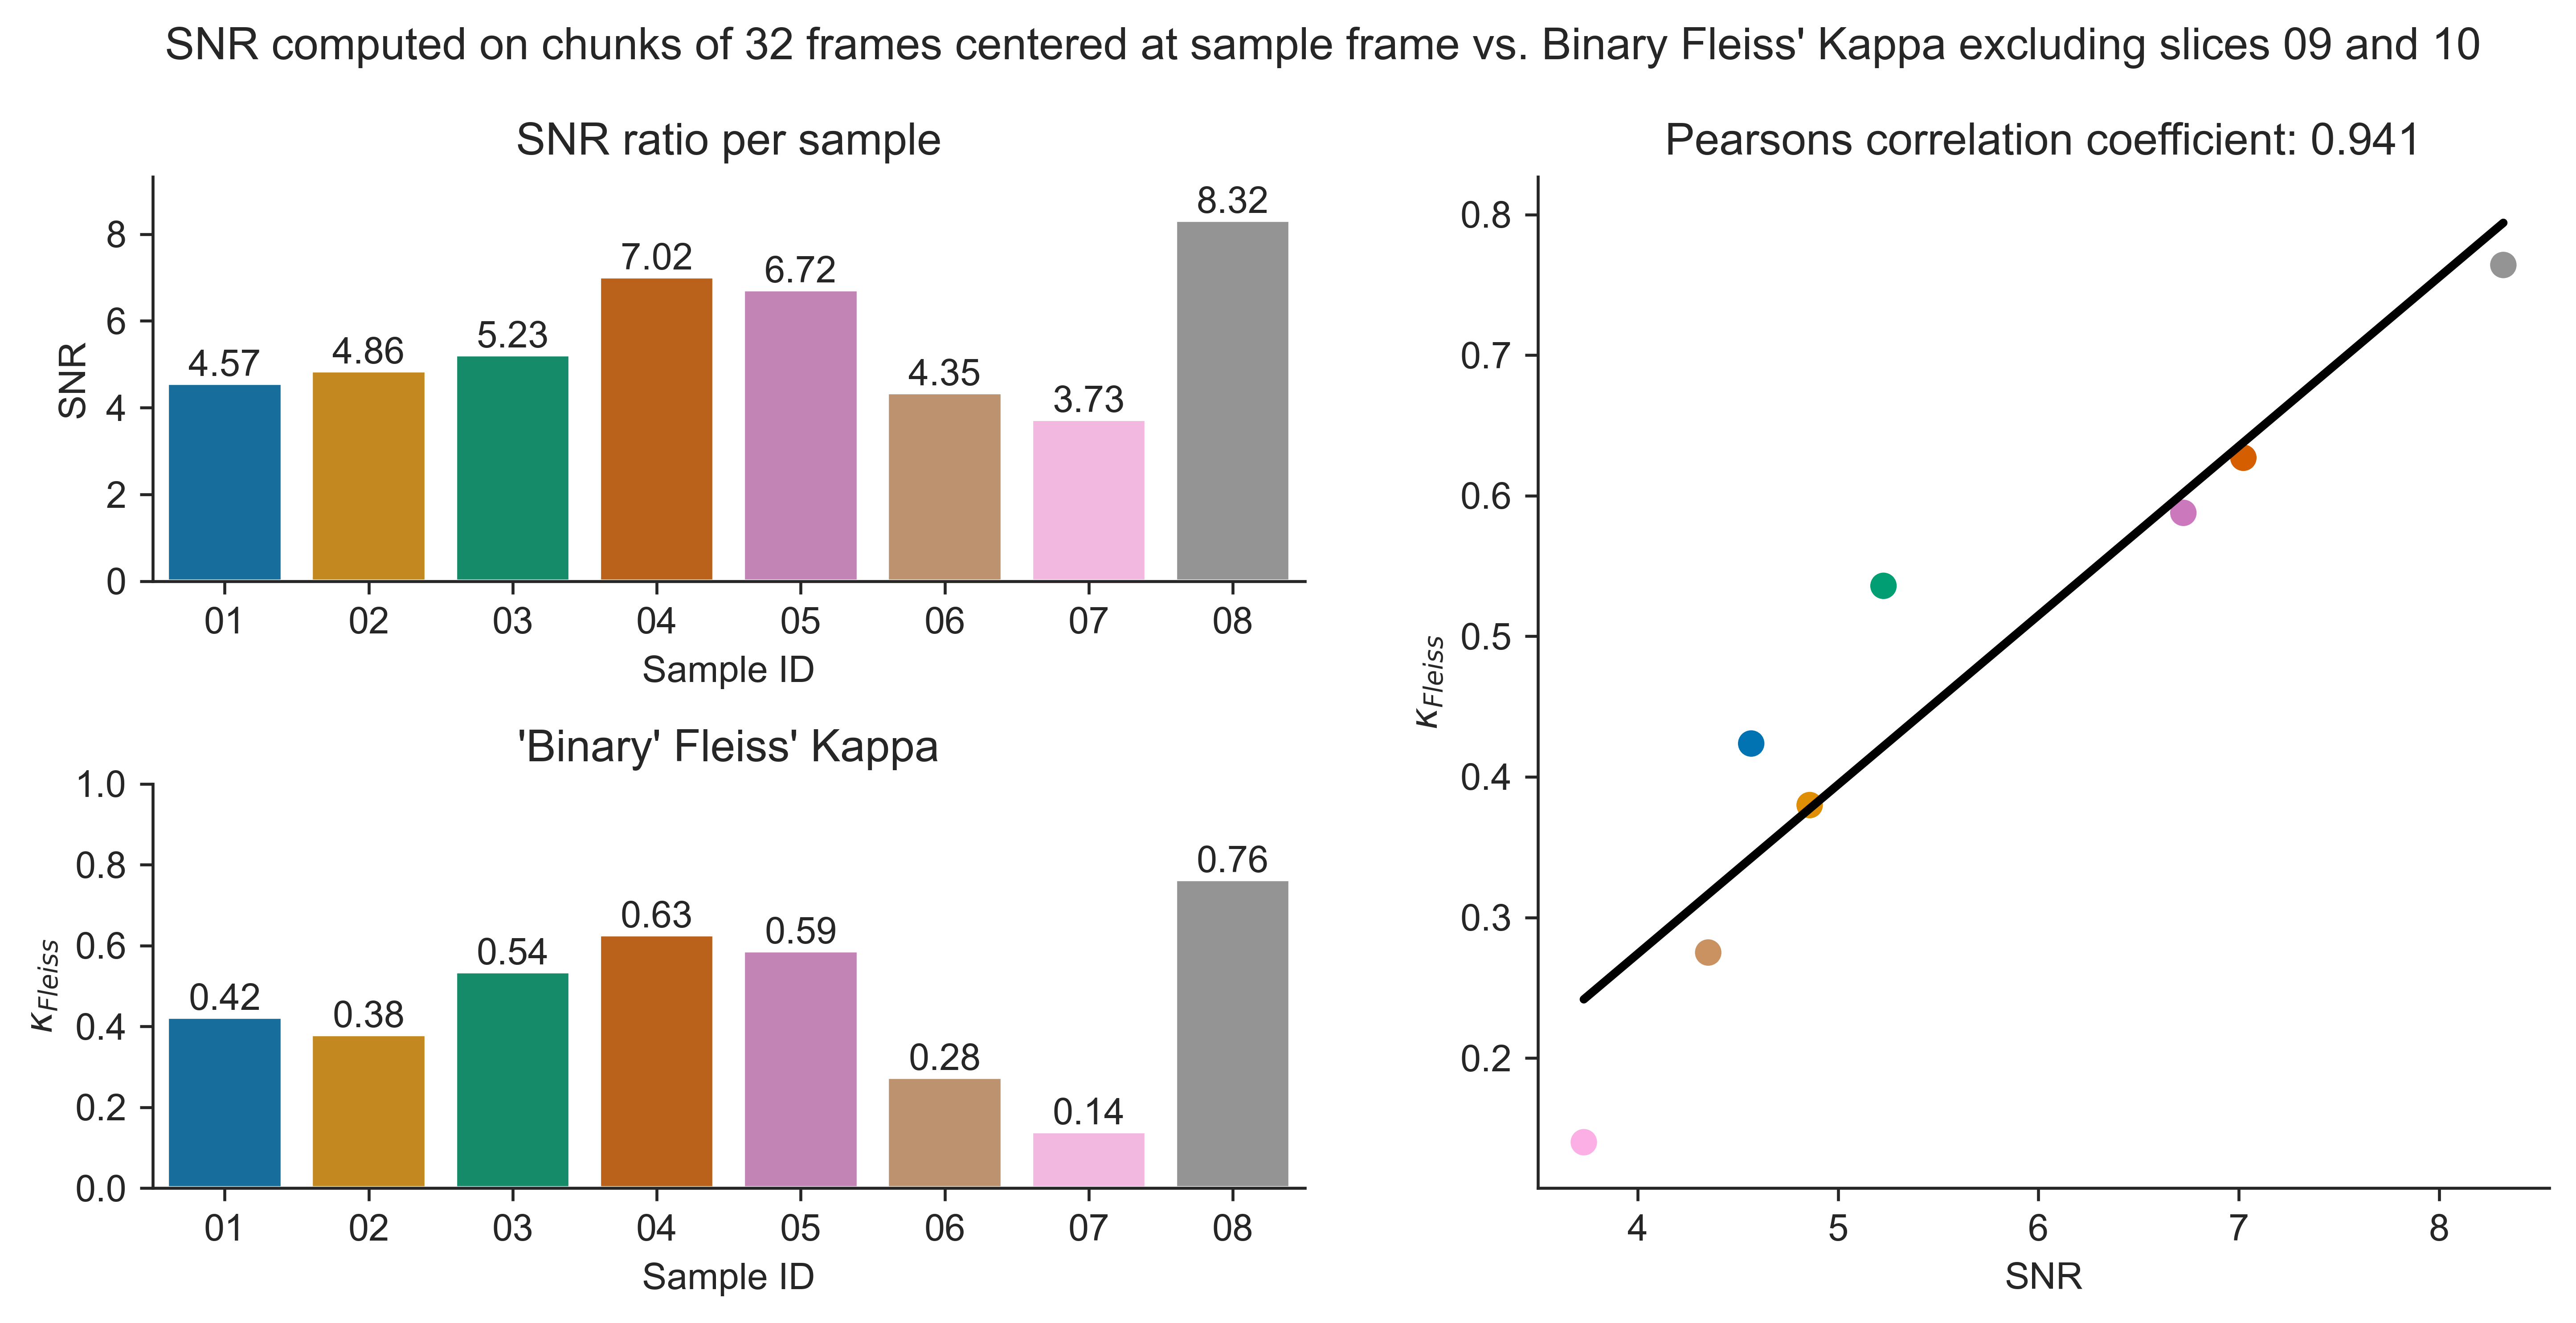

In [31]:
plot_snr_kappa_correlation(
    snr_list=filtered_snr_chunks_list,
    fleiss_kappas_list=filtered_binary_fleiss_kappas_list,
    slice_ids=filtered_slices,
    correlation=filtered_binary_chunks_corr,
    plot_title=f"SNR computed on chunks of {chunk_duration} frames centered at sample frame vs. Binary Fleiss' Kappa excluding slices 09 and 10",
    figsize=(10, 5),
)

In [32]:
# for slice_id in ["01"]:  # slice_ids:
#     movie_id = slice_to_movie_id[slice_id]
#     visualize_pixel_above_percentile(
#         movie_id=movie_id,
#         xs=xs,
#         ys=ys,
#         start_id=start_ids[slice_id],
#         end_id=end_ids[slice_id] + 1,
#         percentile=60,
#     )